# 一、加载数据

数据处理部分：缺失值填充，非数值型标签数值化

In [83]:
import pandas as pd

titanic = pd.read_csv('train.csv',index_col='PassengerId')
print(titanic)
#describe()只能统计数据中的数值量
print(titanic.describe())

             Survived  Pclass  \
PassengerId                     
1                   0       3   
2                   1       1   
3                   1       3   
4                   1       1   
5                   0       3   
...               ...     ...   
887                 0       2   
888                 1       1   
889                 0       3   
890                 1       1   
891                 0       3   

                                                          Name     Sex   Age  \
PassengerId                                                                    
1                                      Braund, Mr. Owen Harris    male  22.0   
2            Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
3                                       Heikkinen, Miss. Laina  female  26.0   
4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
5                                     Allen, Mr. William Henry    male  35.0   
...       

# 二、对数据进行预处理

In [84]:
#由describe()可知，Age的count只有714个是有缺失值的，因此用Age的中位数对此进行填充
titanic['Age'] = titanic['Age'].fillna(titanic['Age'].median())
print(titanic.describe())

         Survived      Pclass         Age       SibSp       Parch        Fare
count  891.000000  891.000000  891.000000  891.000000  891.000000  891.000000
mean     0.383838    2.308642   29.361582    0.523008    0.381594   32.204208
std      0.486592    0.836071   13.019697    1.102743    0.806057   49.693429
min      0.000000    1.000000    0.420000    0.000000    0.000000    0.000000
25%      0.000000    2.000000   22.000000    0.000000    0.000000    7.910400
50%      0.000000    3.000000   28.000000    0.000000    0.000000   14.454200
75%      1.000000    3.000000   35.000000    1.000000    0.000000   31.000000
max      1.000000    3.000000   80.000000    8.000000    6.000000  512.329200


In [85]:
#对数据中我们认为重要的非数值型的量，进行数值表示，方便机器进行学习。例如：Sex
#先查看Sex中有几类数据
print(titanic['Sex'].unique())
# loc[行标签，列标签] 按照行列标签进行切片，
titanic.loc[titanic['Sex']== 'male' ,'Sex'] = 0
titanic.loc[titanic['Sex']== 'female' ,'Sex'] = 1


['male' 'female']


In [86]:
#将上船地点进行数值化表示
print(titanic['Embarked'].unique())

titanic['Embarked'] = titanic['Embarked'].fillna('S')
#数值化表示
titanic.loc[titanic['Embarked']=='S','Embarked'] = 0
titanic.loc[titanic['Embarked']=='C','Embarked'] = 1
titanic.loc[titanic['Embarked']=='Q','Embarked'] = 3

['S' 'C' 'Q' nan]


In [87]:
print('处理后的数据：\n',titanic.head())

处理后的数据：
              Survived  Pclass  \
PassengerId                     
1                   0       3   
2                   1       1   
3                   1       3   
4                   1       1   
5                   0       3   

                                                          Name  Sex   Age  \
PassengerId                                                                 
1                                      Braund, Mr. Owen Harris    0  22.0   
2            Cumings, Mrs. John Bradley (Florence Briggs Th...    1  38.0   
3                                       Heikkinen, Miss. Laina    1  26.0   
4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)    1  35.0   
5                                     Allen, Mr. William Henry    0  35.0   

             SibSp  Parch            Ticket     Fare Cabin  Embarked  
PassengerId                                                           
1                1      0         A/5 21171   7.2500   NaN         0  
2     

# 三、对数据进行分类

1、利用简单的XGboost机器学习算法，进行分类。

In [134]:
from sklearn.externals import joblib
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#我们所需要的特征量features
features = ['Pclass','Age','Sex','SibSp','Parch','Fare','Embarked']

X = titanic.loc[:,features]  #iloc[]切片按行列标签
Y = titanic.loc[:,'Survived']
#print('数据特征X：\n',X)
#print('数据的标签Y：\n',Y)

#将X 和Y split为训练集train 和测试集test
#split X and Y into train and test
seed = 7
test_size = 0.33 #将数据集中33%的数据用来测试
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=test_size,random_state=seed)
print('X_train_shape:',X_train.shape)
print('X_test_shape:',X_test.shape)
print('Y_train_shape:',Y_train.shape)
print('Y_test_shape:',Y_test.shape)
#训练XGBClassifier分类模型
model = XGBClassifier(learning_rate=0.001,n_estimators=2500,
                                max_depth=4, min_child_weight=0,
                                gamma=0, subsample=0.7,
                                colsample_bytree=0.7,
                                scale_pos_weight=1, seed=27,
                                reg_alpha=0.00006).fit(X_train,Y_train)

#保存训练的模型
joblib.dump(model,'titanic_XGboost_model')

#加载模型
load_model = joblib.load('titanic_XGboost_model')

#用测试集对分类的结果进行预测，看分类模型的准确率
Y_pred = load_model.predict(X_test)
print('Y_pred:\n',Y_pred)
print('Y_test:\n',Y_test.values)
predictions = [round(value) for value in Y_pred]
#accuracy准确率为测试集标签的预测与实际测试集标签之间的正确率，也可以用来看我数据的分类是否合理
accuracy = accuracy_score(Y_test,predictions)
print('Accuracy:%.2f%%'%(accuracy*100))

X_train_shape: (596, 7)
X_test_shape: (295, 7)
Y_train_shape: (596,)
Y_test_shape: (295,)
Y_pred:
 [0 0 0 0 1 1 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 1 0 1 0 0 1 1 1 0 0 0 0
 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0
 0 1 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0
 1 0 0 0 1 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 0 1 0 0 0
 0 1 0 0 0 1 0 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0
 1 0 1 1 1 0 1 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 1 0 0 0 1 1 0 0
 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1]
Y_test:
 [0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 1 0 1 1 0 1 1 1 0 1 1 1 0 0 1 0 1
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 1 1 0 0 0
 0 0 1 0 1 0 0 1 0 1 1 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 1 1 0 0 0 1 0 1 0 0 0
 0 1 1 0 1 0 1 1 0 1 0 0 1 0 0 1 0 1 1 1 0 1 0 0 0 0 1 0 0 0 1 1 0 0

2、利用线性回归LinearRegression,进行分类

In [135]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
import numpy as np

#我们所需要的特征量features
features = ['Pclass','Age','Sex','SibSp','Parch','Fare','Embarked']
# print(titanic[features])

model = LinearRegression()
kf = KFold(n_splits = 10,random_state = 1,shuffle=True)

predictions = []

for train,test in kf.split(titanic):
    train_features = titanic[features].iloc[train,:]
    train_label = titanic['Survived'].iloc[train]
    model.fit(train_features,train_label)
    test_predictions = model.predict(titanic[features].iloc[test,:])
    predictions.append(test_predictions)
# print(predictions)
predictions = np.concatenate(predictions,axis=0)
# print(predictions)
#predictions中存放的是test样本中预测的概率
predictions[predictions>0.5]=1
predictions[predictions<=0.5]=0
print('数据的原标签（1表示获救）：\n',titanic['Survived'].to_list())
print('预测的标签（1表示获救）：\n',predictions)
accurary = sum(predictions[predictions==titanic['Survived']])/len(predictions)
print('模型在训练集上的分类的准确度：%.2f%%'%(accuracy*100))

数据的原标签（1表示获救）：
 [0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,

3、利用随机森林进行分类

In [136]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

features = ['Pclass','Age','Sex','SibSp','Parch','Fare','Embarked']
model = RandomForestClassifier(random_state=1,n_estimators=10,min_samples_split=2,min_samples_leaf=1)
# n_estimators=10 随机森林里要构建树的个数  min_samples_split=2 数据最小切分个数  min_samples_leaf=1 叶子结点的最小个数
kf = KFold(n_splits=3,random_state=1,shuffle=False)
scores = cross_val_score(model,titanic[features],titanic['Survived'],cv=kf)
print('模型在训练集上的分类准确率：%.2f%%'%(scores.mean()*100))

模型在训练集上的分类准确率：79.01%


In [91]:
#对随机森林的参数 n_estimators,min_samples_split,min_samples_leaf 简单调节
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

features = ['Pclass','Age','Sex','SibSp','Parch','Fare','Embarked']
model = RandomForestClassifier(random_state=1,n_estimators=50,min_samples_split=4,min_samples_leaf=2)
# n_estimators=10 随机森林里要构建树的个数  min_samples_split=2 数据最小切分个数  min_samples_leaf=1 叶子结点的最小个数
kf = KFold(n_splits=3,random_state=1,shuffle=False)
scores = cross_val_score(model,titanic[features],titanic['Survived'],cv=kf)
print('模型在训练集上的分类准确率：%.2f%%'%(scores.mean()*100))

模型在训练集上的分类准确率：82.38%


4、K近邻算法（既可以用于多分类，也可以用于回归）

In [92]:
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

features = ['Pclass','Age','Sex','SibSp','Parch','Fare','Embarked']
X = titanic.loc[:,features]  #iloc[]切片按行列标签
Y = titanic.loc[:,'Survived']
#print('数据特征X：\n',X)
#print('数据的标签Y：\n',Y)

seed = 7
test_size = 0.33 #将数据集中33%的数据用来测试
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=test_size,random_state=seed)
model = KNN().fit(X_train,Y_train)
y_pred = model.predict(X_test)

print('Y_pred:\n',Y_pred)
print('Y_test:\n',Y_test.values)
predictions = [round(value) for value in Y_pred]
#accuracy准确率为测试集标签的预测与实际测试集标签之间的正确率，也可以用来看我数据的分类是否合理
accuracy = accuracy_score(Y_test,predictions)
print('Accuracy:%.2f%%'%(accuracy*100))

Y_pred:
 [0 0 0 0 1 1 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1 1 1 0 0 0 0
 0 0 1 0 1 0 1 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0
 0 1 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 0 1 0 0 0 1 0 0 0 0 0
 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 0 1 0 0 0
 0 1 0 0 0 1 0 1 0 1 0 1 0 1 1 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0
 1 0 1 1 1 0 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 0 0
 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1]
Y_test:
 [0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 1 0 1 1 0 1 1 1 0 1 1 1 0 0 1 0 1
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 1 1 0 0 0
 0 0 1 0 1 0 0 1 0 1 1 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 1 1 0 0 0 1 0 1 0 0 0
 0 1 1 0 1 0 1 1 0 1 0 0 1 0 0 1 0 1 1 1 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0
 0 0 0 1 1 1 0 1 0 0 1 0 1 0 0 1 1 0 1 0 0 0 0 1 1 1 1 1 0 0 1 0 0 1 0 0 1
 0 1 0 0

# 四、当参数优化后，准确率变化不大，遇到瓶颈后，我们要回归数据集中，从中在找到有用的特征。

通过上面可以发现准确率有小幅提升，但是似乎得到的结果还是不太理想。我们可以发现模型似乎优化的差不多了，使用的特征似乎也已经使用完了。准确率已经达到了瓶颈，但是如果我们还想提高精度的话，还是要回到最原始的数据集里面。对分类器的结果最大的影响还是输入的数据本身。

1、新增特征，家庭成员数和名字长度

In [93]:

#可能家庭成员的数量对是否获救有关，则对该特征进行提取
titanic['FamilySize'] = titanic['SibSp']+titanic['Parch']
#可能名字长度对是否获救也有某种潜在的关联
titanic['NameLength']=titanic['Name'].apply(lambda x:len(x))

提取名字(名字里面包含称呼，如小姐，女士，先生等等)，这些称呼也是有可能对结果产生影响的

In [94]:
#使用正则表达式来对名字进行提取
import re

def get_title(name):
    #名字总是由大小写字母组成，并以点号（.）结束
    #在name中寻找title
    title_search = re.search('([A-Za-z]+)\.',name)
    #如果存在
    if title_search:
        # 数据集的名字如Todoroff, Mr. Lalio 我们要找出其中的Mr 则返回group(1)
        return title_search.group(1)
    return ''

#获取所有title（如Mr，Miss等） 并对其进行统计个数
titles = titanic['Name'].apply(get_title)
print(titles)
print(pd.value_counts(titles))

#将字符标签（Mr，Mrs,Miss等）数值化

titles_mapping = { 
    "Mr": 1,
    "Miss": 2,
    "Mrs": 3,
    "Master": 4,
    "Dr": 5,
    "Rev": 6,
    "Major": 7,
    "Col": 7,
    "Mlle": 8,
    "Mme": 8,
    "Don": 9,
    "Lady": 10,
    "Countess": 10,
    "Jonkheer": 10,
    "Sir": 9,
    "Capt": 7,
    "Ms": 2
}

for k,v in titles_mapping.items():
    titles[k==titles]=v
print(pd.value_counts(titles))

#给原数据添加title特征

PassengerId
1        Mr
2       Mrs
3      Miss
4       Mrs
5        Mr
       ... 
887     Rev
888    Miss
889    Miss
890      Mr
891      Mr
Name: Name, Length: 891, dtype: object
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Major         2
Mlle          2
Capt          1
Mme           1
Countess      1
Jonkheer      1
Don           1
Lady          1
Ms            1
Sir           1
Name: Name, dtype: int64
1     517
2     183
3     125
4      40
5       7
6       6
7       5
10      3
8       3
9       2
Name: Name, dtype: int64


2、新增titles特征

In [95]:
titanic['titles']=titles
print('新增特征后的train数据集：\n',titanic.head())

新增特征后的train数据集：
              Survived  Pclass  \
PassengerId                     
1                   0       3   
2                   1       1   
3                   1       3   
4                   1       1   
5                   0       3   

                                                          Name  Sex   Age  \
PassengerId                                                                 
1                                      Braund, Mr. Owen Harris    0  22.0   
2            Cumings, Mrs. John Bradley (Florence Briggs Th...    1  38.0   
3                                       Heikkinen, Miss. Laina    1  26.0   
4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)    1  35.0   
5                                     Allen, Mr. William Henry    0  35.0   

             SibSp  Parch            Ticket     Fare Cabin  Embarked  \
PassengerId                                                            
1                1      0         A/5 21171   7.2500   NaN         

3、对特征的重要性进行选择，特征虽然提取了很多，但并不是每一个都是重要的。，而随机森林的好处就是特征重要性衡量。

特征重要性解释：在机器学习的训练过程中，对于多个特征来说，假如要对其中某一个特征来衡量它的重要性，我们就不用这个特征的数据来进行训练，而是把这个特征里面的数据全部替换为噪音数据，假如得到的准确率没有太大的变化，那就说明这个特征其实不那么重要，如果得到的准确率相差太大的话，说明这个特征很重要。其他特征的重要衡量以此类推。

提取特征后的数据：
              Pclass   Age  Sex  SibSp  Parch     Fare  Embarked  FamilySize  \
PassengerId                                                                   
1                 3  22.0    0      1      0   7.2500         0           1   
2                 1  38.0    1      1      0  71.2833         1           1   
3                 3  26.0    1      0      0   7.9250         0           0   
4                 1  35.0    1      1      0  53.1000         0           1   
5                 3  35.0    0      0      0   8.0500         0           0   

             NameLength titles  
PassengerId                     
1                    23      1  
2                    51      3  
3                    22      2  
4                    44      3  
5                    24      1  
每个特征的得分列表：
 [24.59567142  1.27768955 68.85199425  0.5342545   1.82976043 14.21323514
  1.72647127  0.20768458 23.69319016 26.98338607]


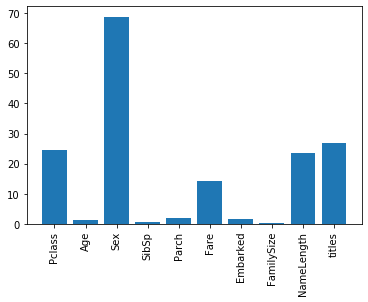

In [96]:
import numpy as np
from sklearn.feature_selection import SelectKBest,f_classif #选择最好特征
import matplotlib.pyplot as plt

features = ['Pclass','Age','Sex','SibSp','Parch','Fare','Embarked','FamilySize','NameLength','titles']
print('提取特征后的数据：\n',titanic[features].head())

#执行特征选择
selector = SelectKBest(f_classif,k=5) 
selector.fit(titanic[features],titanic['Survived']) 

#获取每个特征的得分
scores = -np.log10(selector.pvalues_)
print('每个特征的得分列表：\n',scores)

#绘制得分图，看哪些特征对我们来说是重要的
plt.bar(range(len(features)),scores)
plt.xticks(range(len(features)),features,rotation = 'vertical') #用features中的特征名来代替range(len(features))
plt.show()


上图就是特征重要性的一个柱状图，发现Age等一些特征好像影响不大，和刚开始的假设有较大出入，那么这些没用的特征就可以删除掉，只保留有用的特征即可

# 五、集成算法

只追求精度的情况下，不考虑时间和资源（通常在机器学习的竞赛中用的比较多），可用多种本质上不同的分类算法进行集成。

In [139]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
import numpy as np

#组合我们要集成的算法，将多种算法集成为一个模型
features = ['Pclass','Age','Sex','Fare','Embarked','FamilySize','NameLength','titles']
# features = ['Pclass','Age','Sex','Fare','Embarked','FamilySize','titles']
model = [
    [GradientBoostingClassifier(random_state=1,n_estimators=1000,min_samples_split=4,min_samples_leaf=2,max_depth=4),features],
    [LogisticRegression(random_state = 1,solver = 'liblinear'),features],
]

#初始化和交叉验证
kf = KFold(n_splits=10,shuffle= False,random_state=1)

predictions=[]  
for train,test in kf.split(titanic):
    train_lable = titanic['Survived'].iloc[train]
    full_test_predictions = [] #存放的是一折情况下每个模型的预测的概率
    #对集成算法里的每个算法都用每折数据进行预测
    for model_i,feature in model:
        #用train数据对每个模型进行训练
        model_i.fit(titanic[features].iloc[train,:],train_lable)
        #避免数据类型的错误，都转换成float型
        test_predictions = model_i.predict_proba(titanic[features].iloc[test,:].astype(float))[:,1]
#         test_predictions = model_i.predict(titanic[features].iloc[test,:])
        full_test_predictions.append(test_predictions)
    test_predictions = (full_test_predictions[0]+full_test_predictions[1])/2
    test_predictions[test_predictions > 0.5] = 1
    test_predictions[test_predictions <= 0.5] = 0
    predictions.append(test_predictions)

#将所有折test数据的预测结果放在一个数组中
predictions = np.concatenate(predictions,axis=0)
print('用交叉验证中的每一折test预测的标签：\n',predictions)

print('原始数据的标签：\n',titanic['Survived'].to_list())

#与训练集的数据比较得出正确率
accuracy = sum(predictions == titanic['Survived'])/len(predictions)
print('在训练集上，集成算法的准确性：%.2F%%'%(accuracy*100))



用交叉验证中的每一折test预测的标签：
 [0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0.
 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1.
 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0.
 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0.
 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 0. 0. 0. 1. 0. 1. 1. 0. 0

# 六、预测

由以上各种分类算法可知，集成算法的分类效果最佳，在对test数据集进行预测，我们选用集成算法。

可以将上述过程封装成函数，直接在预测部分调用

In [132]:
import pandas as pd
import re

titanic_test = pd.read_csv('test.csv',index_col = 'PassengerId')
# print('测试数据集：\n',titanic_test)
# print(titanic_test.describe())

#发现Age和Fare 有缺失值，进行填补
titanic_test['Age'] = titanic_test['Age'].fillna(titanic_test['Age'].median())
titanic_test['Fare'] = titanic_test['Fare'].fillna(titanic_test['Fare'].median())
# print(titanic_test.describe())

#对字符型特征数值化
# print(titanic['Sex'].unique())
titanic_test.loc[titanic_test['Sex']=='male','Sex'] = 0
titanic_test.loc[titanic_test['Sex']== 'female' ,'Sex'] = 1

#对字符型特征数值化
# print(titanic_test['Embarked'].unique())
titanic_test.loc[titanic_test['Embarked']=='S','Embarked'] = 0
titanic_test.loc[titanic_test['Embarked']=='C','Embarked'] = 1
titanic_test.loc[titanic_test['Embarked']=='Q','Embarked'] = 3
# print(titanic_test.head())

#对test数据集的其他特征进行处理，添加其他提取的特征

#可能家庭成员的数量对是否获救有关，则对该特征进行提取
titanic_test['FamilySize'] = titanic_test['SibSp']+titanic_test['Parch']
#可能名字长度对是否获救也有某种潜在的关联
titanic_test['NameLength']=titanic_test['Name'].apply(lambda x:len(x))

#使用正则表达式来对名字进行提取
def get_title(name):
    #名字总是由大小写字母组成，并以点号（.）结束
    #在name中寻找title
    title_search = re.search('([A-Za-z]+)\.',name)
    #如果存在
    if title_search:
        # 数据集的名字如Todoroff, Mr. Lalio 我们要找出其中的Mr 则返回group(1)
        return title_search.group(1)
    return ''

#获取所有title（如Mr，Miss等） 并对其进行统计个数
titles = titanic_test['Name'].apply(get_title)
# print(titles)
# print(pd.value_counts(titles))

#将字符标签（Mr，Mrs,Miss等）数值化

titles_mapping = { 
    "Mr": 1,
    "Miss": 2,
    "Mrs": 3,
    "Master": 4,
    "Dr": 5,
    "Rev": 6,
    "Major": 7,
    "Col": 7,
    "Mlle": 8,
    "Mme": 8,
    "Dona": 9,
    "Lady": 10,
    "Countess": 10,
    "Jonkheer": 10,
    "Sir": 9,
    "Capt": 7,
    "Ms": 2
}

for k,v in titles_mapping.items():
    titles[k==titles]=v
# print(pd.value_counts(titles))
titanic_test['titles']=titles
print(titanic_test.head())

#使用集成算法预测
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np

#组合我们要集成的算法，将多种算法集成为一个模型
features = ['Pclass','Age','Sex','Fare','Embarked','FamilySize','titles']
model = [
    [GradientBoostingClassifier(random_state=1,n_estimators=1000,min_samples_split=4,min_samples_leaf=2,max_depth=4),features],
    [LogisticRegression(random_state = 1,solver = 'liblinear'),features],
]

full_predictions = []
for model_i,features in model:
    # 用整个训练集对模型进行训练.
    model_i.fit(titanic[features],titanic['Survived'])
    # 使用测试数据集进行预测。我们必须将所有列都转换为浮点数以避免错误.
    predictions = model_i.predict_proba(titanic_test[features].astype(float))[:, 1]
    predictions[predictions <= .5] = 0
    predictions[predictions > .5] = 1
    full_predictions.append(predictions)
print(predictions)

#将预测结果保存为CSV文件
test = pd.DataFrame(predictions,index = titanic_test.index,dtype = 'int',columns=['Survived'])
print(test)
test.to_csv('predictions_Survived.csv')
print('Done')




             Pclass                                          Name  Sex   Age  \
PassengerId                                                                    
892               3                              Kelly, Mr. James    0  34.5   
893               3              Wilkes, Mrs. James (Ellen Needs)    1  47.0   
894               2                     Myles, Mr. Thomas Francis    0  62.0   
895               3                              Wirz, Mr. Albert    0  27.0   
896               3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)    1  22.0   

             SibSp  Parch   Ticket     Fare Cabin  Embarked  FamilySize  \
PassengerId                                                               
892              0      0   330911   7.8292   NaN         3           0   
893              1      0   363272   7.0000   NaN         0           1   
894              0      0   240276   9.6875   NaN         3           0   
895              0      0   315154   8.6625   NaN         0     